**In case of problems or questions, please first check the list of [Frequently Asked Questions (FAQ)](https://stardist.net/docs/faq.html).**

Please shutdown all other training/prediction notebooks before running this notebook (as those might occupy the GPU memory otherwise).

In [1]:
!pip install stardist

In [2]:
!pip install csbdeep

In [3]:
!pip install tensorflow

In [4]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib
matplotlib.rcParams["image.interpolation"] = None
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
from tifffile import imread
from csbdeep.utils import Path, normalize
from csbdeep.io import save_tiff_imagej_compatible

from stardist import random_label_cmap
from stardist.models import StarDist3D

np.random.seed(6)
lbl_cmap = random_label_cmap()

# Configs

In [5]:
import h5py
import os
from tifffile import imsave
from scipy.ndimage import zoom
import tifffile

In [6]:
from yacs.config import CfgNode as CN

_C = CN()

_C.ROOT = "/n/pfister_lab2/Lab/zudilin/data/NucExM/NucExM-Release"
#_C.VOLUMES = ["image0.h5","image1.h5","image2.h5","image3.h5"]
_C.VOLUMES = ["image4.h5"]
_C.H5KEY = 'main'

In [7]:
def get_cfg_defaults():
  """Get a yacs CfgNode object with default values for my_project."""
  # Return a clone so that the defaults will not be altered
  # This is for the "local variable" use pattern
  return _C.clone()

cfg = get_cfg_defaults()
#cfg.merge_from_file("./configs/base_setup.yaml")
cfg.freeze()

In [8]:
demo_model = True

if demo_model:
    print (
        "NOTE: This is loading a previously trained demo model!\n"
        "      Please set the variable 'demo_model = False' to load your own trained model.",
        file=sys.stderr, flush=True
    )
    model = StarDist3D.from_pretrained('3D_demo')
else:
    model = StarDist3D(None, name='stardist', basedir='models')
None;

NOTE: This is loading a previously trained demo model!
      Please set the variable 'demo_model = False' to load your own trained model.


Found model '3D_demo' for 'StarDist3D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.707933, nms_thresh=0.3.


In [9]:
for i, vol_name in enumerate(cfg.VOLUMES):
    print(vol_name)
    h5 = h5py.File(os.path.join(cfg.ROOT, vol_name), 'r')
    vol = np.asarray(h5.get(list(h5.keys())[0]))#[140:204, :, :]
    vol = zoom(vol, (1,1/4,1/4), order=3)
    n_channel = 1 if vol.ndim == 3 else vol.shape[-1]
    axis_norm = (0,1,2)   # normalize channels independently
    if n_channel > 1:
        print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))


image4.h5


# Data

We assume that data has already been downloaded in via notebook [1_data.ipynb](1_data.ipynb).  
We now load images from the sub-folder `test` that have not been used during training.

In [13]:
for i, vol_name in enumerate(cfg.VOLUMES):
    print(vol_name)
    h5 = h5py.File(os.path.join(cfg.ROOT, vol_name), 'r')
    vol = np.asarray(h5.get(list(h5.keys())[0]))#[140:204, :, :]
    print(vol.shape)
    vol = zoom(vol, (1,1/4,1/4), order=3)
    print(vol.shape)
    n_channel = 1 if vol.ndim == 3 else vol.shape[-1]
    axis_norm = (0,1,2)   # normalize channels independently
    if n_channel > 1:
        print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))
    print(np.min(vol),np.max(vol))
    img = normalize(vol, 1,99.8, axis=axis_norm)
    print("start inferencing")
    labels, details = model.predict_instances(img)
    print("done inferencing") 
    with h5py.File(os.path.join("/n/pfister_lab2/Lab/leander/cerberus/img_toolbox/stardist_output", vol_name.split(".")[0]+"_start_dist_label.h5"),"w") as h5:
        h5.create_dataset("main", data=labels)


image4.h5
(255, 2048, 2048)
(255, 512, 512)
0 255
start inferencing
done inferencing


In [16]:
print(os.path.join("/n/pfister_lab2/Lab/leander/cerberus/img_toolbox/stardist_output", vol_name.split(".")[0]+"_start_dist_label.h5"))

/n/pfister_lab2/Lab/leander/cerberus/img_toolbox/stardist_output/image4_start_dist_label.h5


(255, 512, 512)


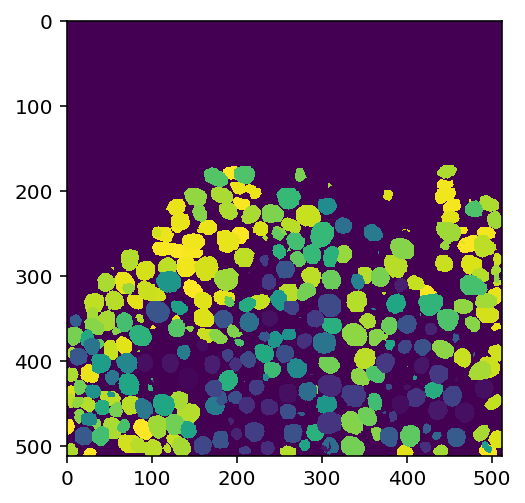

In [17]:
h5 = h5py.File(os.path.join("/n/pfister_lab2/Lab/leander/cerberus/img_toolbox/stardist_output", vol_name.split(".")[0]+"_start_dist_label.h5"), 'r')
vol = np.asarray(h5.get(list(h5.keys())[0]))
print(vol.shape)
plt.imshow(vol[59,:,:])

In [15]:
n_channel = 1 if vol.ndim == 3 else vol.shape[-1]
axis_norm = (0,1,2)   # normalize channels independently
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))

In [31]:
X = [vol[:,0:vs[1]//2,0:vs[2]//2], vol[:,vs[1]//2:vs[1],0:vs[2]//2], vol[:,0:vs[1]//2,vs[2]//2:vs[2]], vol[:,vs[1]//2:vs[1],vs[2]//2:vs[2]] ]
n_channel = 1 if X[0].ndim == 3 else X[0].shape[-1]
axis_norm = (0,1,2)   # normalize channels independently
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))

(64, 170, 170)
(64, 171, 170)
(64, 170, 171)
(64, 171, 171)


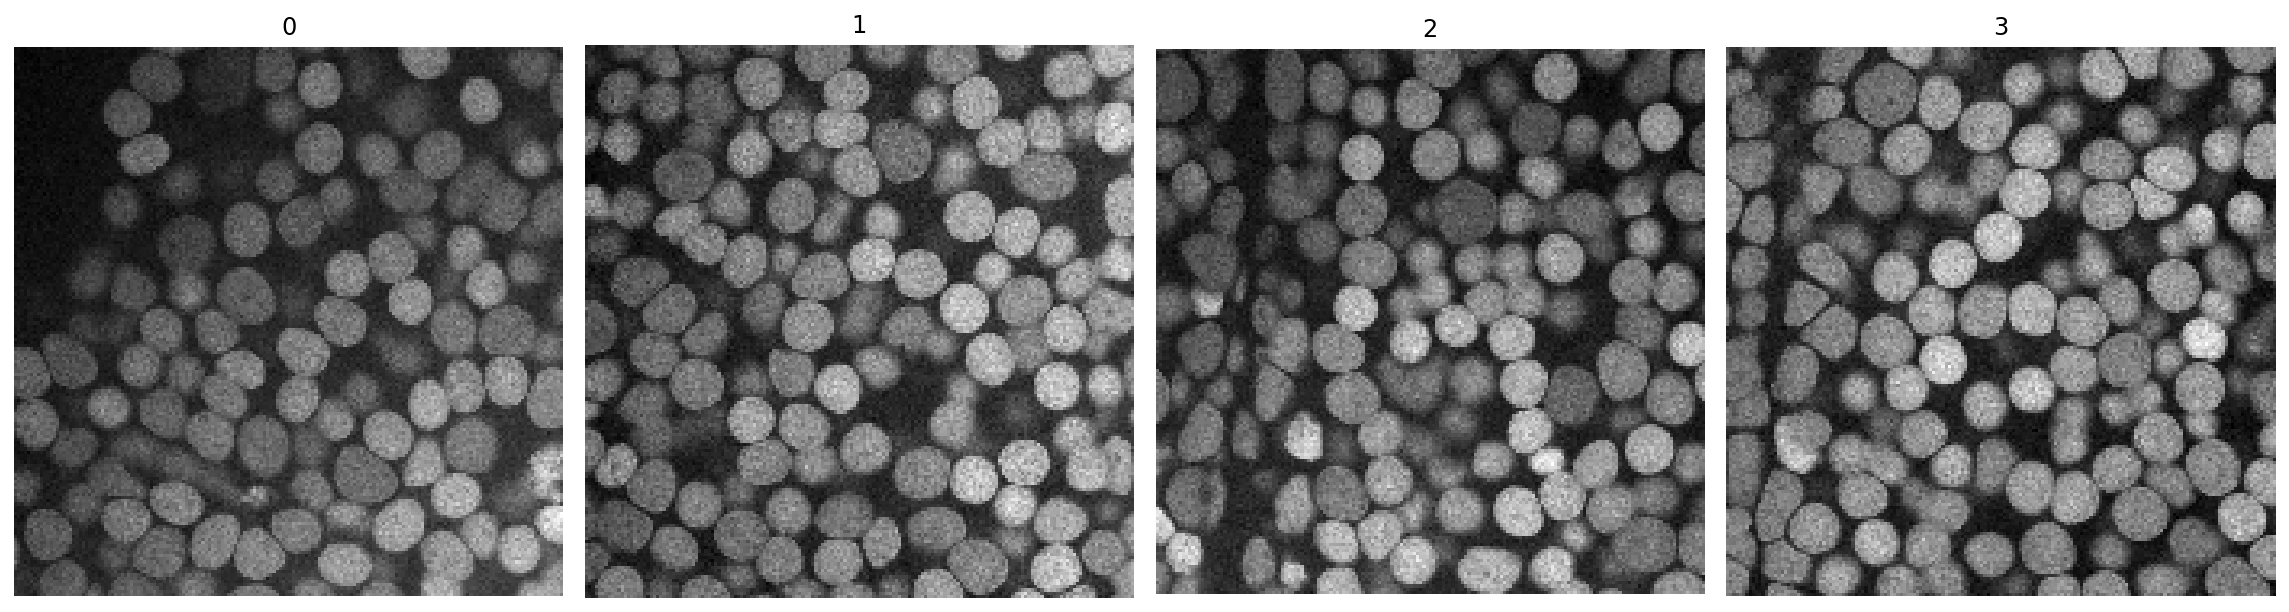

In [32]:
# show all test images
if True:
    fig, ax = plt.subplots(1,4, figsize=(16,16))
    for i,(a,x) in enumerate(zip(ax.flat, X)):
        print(x.shape)
        a.imshow(x[x.shape[0]//2],cmap='gray')
        a.set_title(i)
    [a.axis('off') for a in ax.flat]
    plt.tight_layout()
None;

# Load trained model

If you trained your own StarDist model (and optimized its thresholds) via notebook [2_training.ipynb](2_training.ipynb), then please set `demo_model = False` below.

In [17]:
demo_model = True

if demo_model:
    print (
        "NOTE: This is loading a previously trained demo model!\n"
        "      Please set the variable 'demo_model = False' to load your own trained model.",
        file=sys.stderr, flush=True
    )
    model = StarDist3D.from_pretrained('3D_demo')
else:
    model = StarDist3D(None, name='stardist', basedir='models')
None;

NOTE: This is loading a previously trained demo model!
      Please set the variable 'demo_model = False' to load your own trained model.


Found model '3D_demo' for 'StarDist3D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.707933, nms_thresh=0.3.


## Prediction

Make sure to normalize the input image beforehand or supply a `normalizer` to the prediction function.

Calling `model.predict_instances` will
- predict object probabilities and star-convex polygon distances (see `model.predict` if you want those)
- perform non-maximum suppression (with overlap threshold `nms_thresh`) for polygons above object probability threshold `prob_thresh`.
- render all remaining polygon instances in a label image
- return the label instances image and also the details (coordinates, etc.) of all remaining polygons

In [18]:
img = normalize(vol, 1,99.8, axis=axis_norm)
labels, details = model.predict_instances(img)

In [19]:
print(vol.shape)

(64, 341, 341)


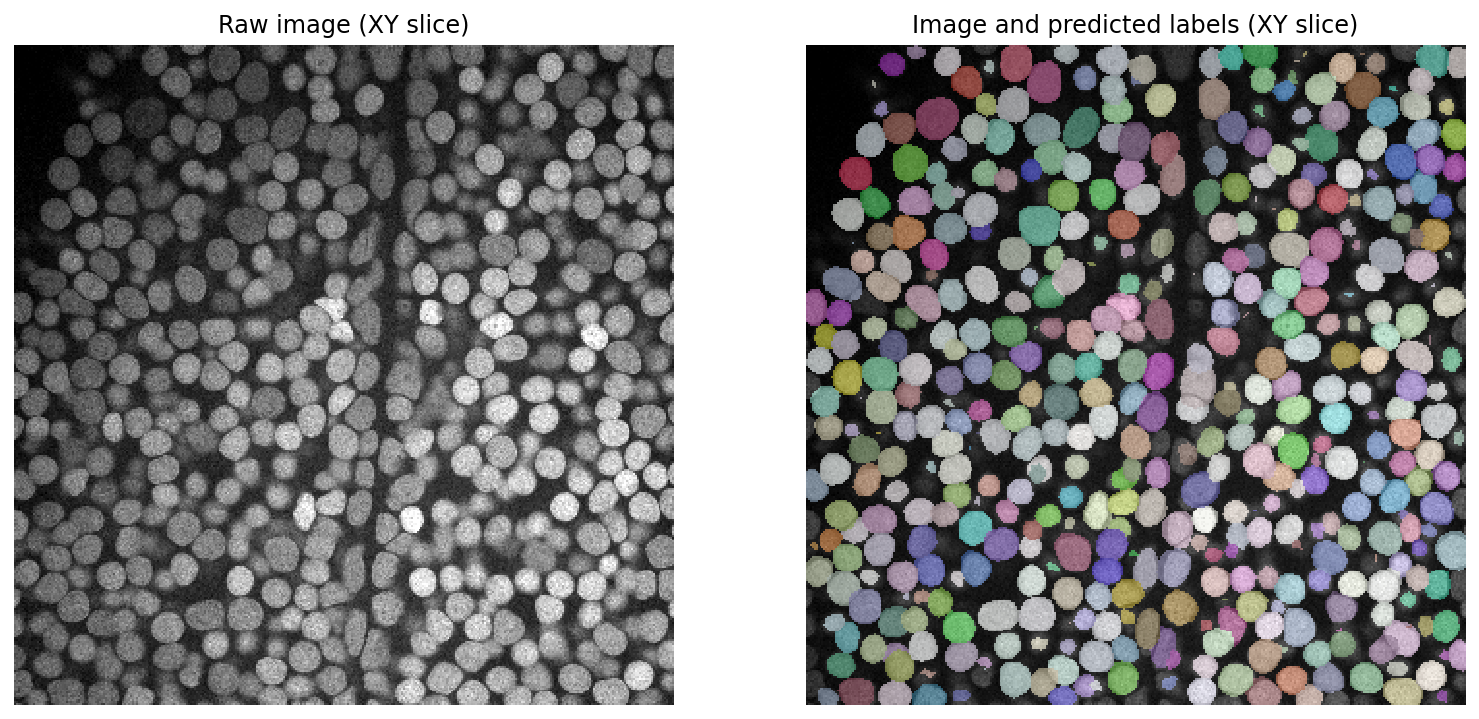

In [38]:
plt.figure(figsize=(13,10))
z = max(0, img.shape[0] // 2 - 5)
plt.subplot(121)
plt.imshow((img if img.ndim==3 else img[...,:3])[z], clim=(0,1), cmap='gray')
plt.title('Raw image (XY slice)')
plt.axis('off')
plt.subplot(122)
plt.imshow((img if img.ndim==3 else img[...,:3])[z], clim=(0,1), cmap='gray')
plt.imshow(labels[z], cmap=lbl_cmap, alpha=0.5)
plt.title('Image and predicted labels (XY slice)')
plt.axis('off');